Hojas disponibles: ['Data', 'Legend']
Tamaño del dataframe (filas, columnas): (8789, 29)

Columna: Fluid 1 Superficial Velocity -> primeros valores:
['[m/s]' '0.00386498545398165' '0.00604693202388647' '0.00957276683627678'
 '0.037531626773176' '0.0148016295994528' '0.0951690966361475'
 '0.0242743014070414']

Columna: Fluid 1 Density -> primeros valores:
['[kg/m³]' '999' '999' '999' '999' '999' '999' '999']

Columna: Fluid 1 Viscosity -> primeros valores:
['[Pa.s]' '0.001139' '0.001139' '0.001139' '0.001139' '0.001139'
 '0.001139' '0.001139']

Columna: Internal Diameter -> primeros valores:
['[m]' '0.0255' '0.0255' '0.0255' '0.0255' '0.0255' '0.0255' '0.0255']

Columna: None -> NO encontrada o es None

Columna: Pressure Drop -> NO encontrada o es None
Fluid 1 Superficial Velocity: valores numéricos encontrados = 8788, median = 0.391295394817073
Fluid 1 Density: valores numéricos encontrados = 8788, median = 999.0
Fluid 1 Viscosity: valores numéricos encontrados = 8788, median = 0.00113

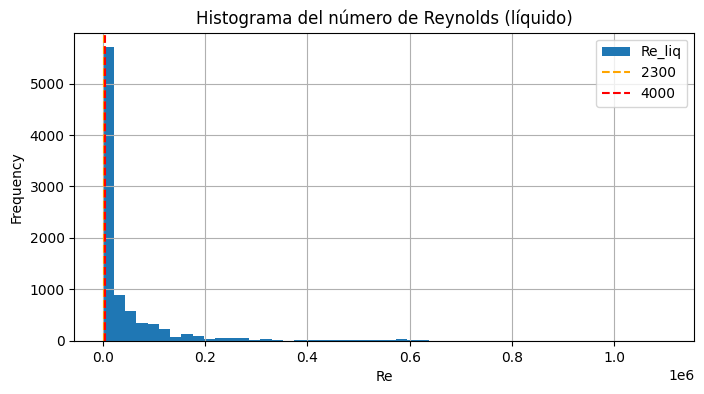

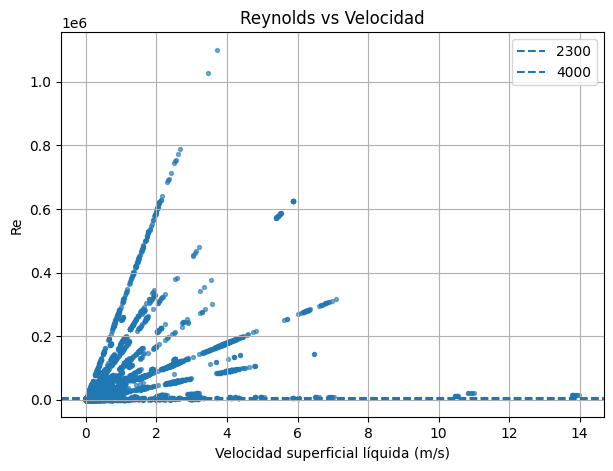

Columna Reynolds encontrada en Excel: Fluid 1 Reynolds
Re calculados en filas: 8788

Estadísticas de discrepancia (solo donde ambos existen):
       Re_existing_num       Re_calc   Re_abs_diff   Re_rel_diff
count     8.788000e+03  8.788000e+03  8.788000e+03  8.788000e+03
mean      4.126409e+04  4.126409e+04  1.313166e-15  1.782060e-19
std       8.500021e+04  8.500021e+04  8.124938e-14  5.646805e-18
min       1.336404e-01  1.336404e-01  0.000000e+00  0.000000e+00
25%       1.114418e+03  1.114418e+03  0.000000e+00  0.000000e+00
50%       7.451118e+03  7.451118e+03  0.000000e+00  0.000000e+00
75%       4.415456e+04  4.415456e+04  0.000000e+00  0.000000e+00
max       1.101054e+06  1.101054e+06  7.275958e-12  2.139003e-16
Filas con discrepancia significativa (flag True): 0


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


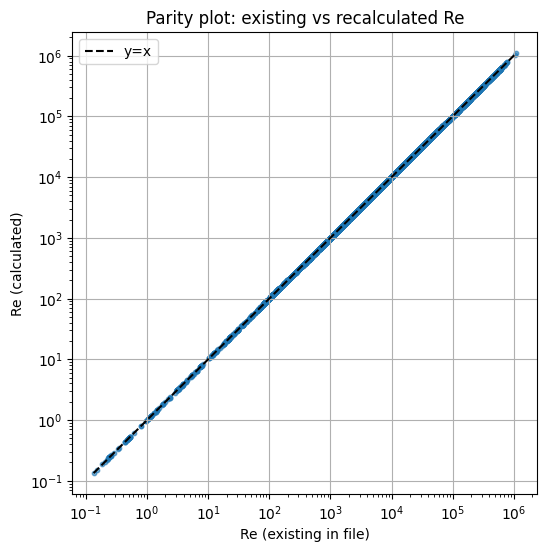

No hay discrepancias significativas encontradas con el umbral por defecto.
Guardado: reynolds_comparison.csv


In [1]:

#Proyecto: Cálculo del número de Reynolds a partir de un dataset experimental
#Objetivo: cargar el archivo Excel (Mendeley Flow Database), calcular el número de Reynolds por cada fila, clasificar el régimen (laminar/transición/turbulento) y generar recomendaciones simples sobre la bomba.  
#Reynolds: Re=ρvD/μ

# IMPORTS: librerías básicas que necesitarás en Kaggle
import pandas as pd # linear algebra
import numpy as np # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib.pyplot as plt
import os

# Opcional: mostrar gráficos dentro del notebook
%matplotlib inline

# Control visual (no obligatorio)
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 200)


#Archivo Excel con datos Reales 
file_path = "/kaggle/input/flow-database-mendeley/Flow_Database_Mendeley.xlsx"  


# Cargamos la hoja 'Data' que es la que contiene los registros experimentales
xls = pd.ExcelFile("/kaggle/input/flow-database-mendeley/Flow_Database_Mendeley.xlsx")
print("Hojas disponibles:", xls.sheet_names)

#Hay dos hojas en el archivo Excel. Nos aseguramos de leer la correcta "Data" y lo comprobamos con df.head 
df = pd.read_excel("/kaggle/input/flow-database-mendeley/Flow_Database_Mendeley.xlsx", sheet_name="Data")
print("Tamaño del dataframe (filas, columnas):", df.shape)
df.head(6)

# Mostrar todas las columnas para que veas sus nombres exactos
#for i, c in enumerate(df.columns):
#    print(f"{i:03d}", c)

# Mostrar info rápida (cuántos no nulos por columna)
#print("\nInformación rápida:")
#display(df.info())

# Ver ejemplos (algunas filas)
#df.head(8)

# === Definición de variables para el fluido 1===
col_vel = "Fluid 1 Superficial Velocity"   # velocidad superficial del líquido (m/s)
col_rho = "Fluid 1 Density"               # densidad (kg/m3)
col_mu  = "Fluid 1 Viscosity"             # viscosidad (Pa.s)
col_D   = "Internal Diameter"             # diámetro (m)
col_Q   = None                             # opcional: nombre de columna de caudal (m3/s)
col_dp  = "Pressure Drop"                  # opcional: caída de presión (Pa) o Pressure Loss

# Muestra las primeras 10 valores de las columnas mapeadas (para comprobar)
for c in [col_vel, col_rho, col_mu, col_D, col_Q, col_dp]:
    if c is not None and c in df.columns:
        print(f"\nColumna: {c} -> primeros valores:")
        print(df[c].dropna().astype(str).values[:8])
    else:
        print(f"\nColumna: {c} -> NO encontrada o es None")
        
#¿Qué hace exactamente?
#cols_to_convert es la lista de nombres de columna que quieres usar (velocidad, densidad, viscosidad, diámetro, caudal, caída de presión).
#Para cada columna existente en el df, crea una nueva columna con el sufijo _num (por ejemplo "Fluid 1 Density_num"), que contiene los mismos valores convertidos a tipo numérico.
#pd.to_numeric(..., errors='coerce'):
#intenta convertir cada celda a número (float).
#si una celda no puede convertirse (por ejemplo tiene texto "0.001 Pa.s" o "N/A"), la convierte en NaN (eso es lo que hace errors='coerce').
#Importante: no lanza error si hay strings; en vez de eso pone NaN.

#¿Por qué es útil?
#Te asegura que las columnas que vayas a usar para cálculos estén en formato numérico (float).
#Evita que operaciones aritméticas fallen por tipos mixtos (strings + números).

# Convertimos a numérico (coerce convierte a NaN si no puede)
cols_to_convert = [col_vel, col_rho, col_mu, col_D, col_Q, col_dp]
for c in cols_to_convert:
    if c is not None and c in df.columns:
        df[c + "_num"] = pd.to_numeric(df[c], errors='coerce')

# Mostrar recuentos numéricos
for c in cols_to_convert:
    if c is not None and c in df.columns:
        s = df[c + "_num"]
        print(f"{c}: valores numéricos encontrados = {s.notna().sum()}, median = {s.median()}")


#¿Qué hace?
#Crea una columna v_liq_m_s inicializada con NaN (velocidad líquida en m/s).
#Si existe una columna de velocidad en tus datos (por ejemplo "Fluid 1 Superficial Velocity"), copia su versión numérica (*_num) en v_liq_m_s.

#Notas y por qué lo hacemos
#Preferimos usar la velocidad medida si ya está en los datos.
#Mantener v_liq_m_s como columna “final” facilita usarla más tarde sin repetir nombres.
# Creamos columna final 'v_liq_m_s' que usaremos para Re
df["v_liq_m_s"] = np.nan

# 1) Si existe columna directa de velocidad, usarla
if col_vel is not None and col_vel in df.columns:
    df["v_liq_m_s"] = df[col_vel + "_num"]

# 2) Si no existe velocidad pero sí Q (caudal) y D, calcular v = Q / Area
if df["v_liq_m_s"].isna().all() and col_Q is not None and col_Q in df.columns and col_D is not None and col_D in df.columns:
    def area_from_D(D):
        return math.pi * (D**2) / 4.0
    mask = df[col_Q + "_num"].notna() & df[col_D + "_num"].notna()
    df.loc[mask, "v_liq_m_s"] = df.loc[mask, col_Q + "_num"] / df.loc[mask, col_D + "_num"].apply(area_from_D)
    print("Velocidad calculada desde Q y D para filas:", mask.sum())

# Mostrar resumen de velocidades detectadas
print("Filas con velocidad disponible:", df["v_liq_m_s"].notna().sum())
df["v_liq_m_s"].describe()


# Definición de la función Reynolds
def reynolds_number(rho, v, D, mu):
    # Re = rho * v * D / mu
    try:
        return (rho * v * D) / mu
    except:
        return np.nan

# Calcular Re donde tengamos rho, v, D, mu
mask_re = (df[col_rho + "_num"].notna()) & (df["v_liq_m_s"].notna()) & (df[col_D + "_num"].notna()) & (df[col_mu + "_num"].notna())
df.loc[mask_re, "Re_liq"] = (df.loc[mask_re, col_rho + "_num"] * df.loc[mask_re, "v_liq_m_s"] * df.loc[mask_re, col_D + "_num"]) / df.loc[mask_re, col_mu + "_num"]

print("Re calculados en filas:", df["Re_liq"].notna().sum())
df["Re_liq"].describe()

# Clasificación sencilla del régimen
def clasificar_re(Re):
    if np.isnan(Re):
        return "No calculado"
    if Re < 2300:
        return "Laminar"
    elif Re < 4000:
        return "Transición"
    else:
        return "Turbulento"

df["Regimen"] = df["Re_liq"].apply(clasificar_re)

# Reglas simples para "¿necesita bomba mejor?"
def recomendacion_simple(row):
    Re = row["Re_liq"]
    # Si existe columna de caída de presión (numérica) la usamos también
    drop_col = col_dp + "_num" if (col_dp is not None and col_dp in df.columns) else None
    if np.isnan(Re):
        return "No calculado (faltan datos)"
    if Re > 80000:
        return "Flujo muy turbulento — posible necesidad de bomba más potente / inspección"
    if Re < 2000:
        return "Flujo laminar — posible baja eficiencia; revisar selección de bomba"
    # Si hay caída de presión y es alta (>20000 Pa ~ 2 bar), advertir
    if drop_col and pd.notna(row.get(drop_col, np.nan)) and row[drop_col] > 20000:
        return "Pérdida de carga alta — considerar bomba más potente"
    return "Bomba probablemente adecuada"

df["Recomendacion"] = df.apply(recomendacion_simple, axis=1)

# Mostrar conteos por régimen
print(df["Regimen"].value_counts(dropna=False))
df[["Re_liq", "Regimen", "Recomendacion"]].head(8)

# Histograma del Re
plt.figure(figsize=(8,4))
df["Re_liq"].dropna().plot(kind="hist", bins=50)
plt.axvline(2300, color='orange', linestyle='--', label='2300')
plt.axvline(4000, color='red', linestyle='--', label='4000')
plt.title("Histograma del número de Reynolds (líquido)")
plt.xlabel("Re")
plt.legend()
plt.grid(True)
plt.show()

# Scatter: Re vs velocidad
plt.figure(figsize=(7,5))
mask = df["Re_liq"].notna() & df["v_liq_m_s"].notna()
plt.scatter(df.loc[mask, "v_liq_m_s"], df.loc[mask, "Re_liq"], s=8, alpha=0.6)
plt.xlabel("Velocidad superficial líquida (m/s)")
plt.ylabel("Re")
plt.title("Reynolds vs Velocidad")
plt.axhline(2300, linestyle='--', label='2300')
plt.axhline(4000, linestyle='--', label='4000')
plt.legend()
plt.grid(True)
plt.show()

# ---------- Comparar Re existente en Excel vs Re calculado por ti ----------


# 1) Detectar columna de Re ya existente (busca "reyn" en el nombre)
existing_re_col = None
for c in df.columns:
    if "reyn" in c.lower() or c.lower().strip() in ["re","reynolds"]:
        existing_re_col = c
        break

print("Columna Reynolds encontrada en Excel:", existing_re_col)

# 2) Asegurarnos de tener la versión numérica de los inputs (si no, crea *_num)
# Cambia estos nombres si usaste otros en tu notebook
col_rho = "Fluid 1 Density"
col_mu  = "Fluid 1 Viscosity"
col_D   = "Internal Diameter"
col_vel = "Fluid 1 Superficial Velocity"

for c in [col_rho, col_mu, col_D, col_vel]:
    if c in df.columns and (c + "_num") not in df.columns:
        df[c + "_num"] = pd.to_numeric(df[c], errors='coerce')

# 3) Recalcular Re (si no lo hiciste ya)
df["Re_calc"] = np.nan
mask = df[[col_rho + "_num", col_mu + "_num", col_D + "_num", col_vel + "_num"]].notna().all(axis=1)
df.loc[mask, "Re_calc"] = (df.loc[mask, col_rho + "_num"] * df.loc[mask, col_vel + "_num"] * df.loc[mask, col_D + "_num"]) / df.loc[mask, col_mu + "_num"]
print("Re calculados en filas:", df["Re_calc"].notna().sum())

# 4) Si existe Re en el Excel, convertir a numérico y comparar
if existing_re_col is not None:
    df["Re_existing_num"] = pd.to_numeric(df[existing_re_col], errors='coerce')
    # Calculamos diferencia absoluta y relativa
    df["Re_abs_diff"] = (df["Re_calc"] - df["Re_existing_num"]).abs()
    df["Re_rel_diff"] = df["Re_abs_diff"] / df["Re_existing_num"].abs().replace(0, np.nan)
    # Estadísticas de la discrepancia
    print("\nEstadísticas de discrepancia (solo donde ambos existen):")
    print(df[["Re_existing_num","Re_calc","Re_abs_diff","Re_rel_diff"]].dropna().describe())

    # 5) Marcar filas con discrepancia significativa
    # umbral relativo por defecto: 5% (0.05) o umbral absoluto si Re pequeño (p.e. 100)
    rel_thresh = 0.05
    abs_thresh = 100.0
    df["Re_discrepancy_flag"] = False
    mask_both = df["Re_existing_num"].notna() & df["Re_calc"].notna()
    df.loc[mask_both & ((df["Re_rel_diff"] > rel_thresh) & df["Re_existing_num"].abs()>0), "Re_discrepancy_flag"] = True
    df.loc[mask_both & (df["Re_abs_diff"] > abs_thresh) & (df["Re_existing_num"].abs()<=0), "Re_discrepancy_flag"] = True

    print("Filas con discrepancia significativa (flag True):", df["Re_discrepancy_flag"].sum())

    # 6) Parity plot (Re_existing vs Re_calc)
    plt.figure(figsize=(6,6))
    plt.scatter(df["Re_existing_num"], df["Re_calc"], s=10, alpha=0.6)
    maxi = np.nanmax([df["Re_existing_num"].max(), df["Re_calc"].max()])
    mini = np.nanmin([df["Re_existing_num"].min(), df["Re_calc"].min()])
    plt.plot([mini, maxi],[mini, maxi], 'k--', label='y=x')
    plt.xlabel("Re (existing in file)")
    plt.ylabel("Re (calculated)")
    plt.title("Parity plot: existing vs recalculated Re")
    plt.grid(True)
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    # 7) Mostrar ejemplos discrepantes (primeras 10)
    discrep = df[df["Re_discrepancy_flag"]].sort_values("Re_rel_diff", ascending=False)
    if not discrep.empty:
        display(discrep.head(10)[[existing_re_col, "Re_existing_num","Re_calc","Re_abs_diff","Re_rel_diff","Re_discrepancy_flag"]])
    else:
        print("No hay discrepancias significativas encontradas con el umbral por defecto.")

else:
    print("No encontré una columna de Reynolds en el Excel; sólo se calcula Re desde inputs.")

# 8) Guardar un CSV con ambos Re y el flag para inspección manual
out_name = "reynolds_comparison.csv"
df.to_csv(out_name, index=False)
print("Guardado:", out_name)


